In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt



In [66]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=8

In [139]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/code/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [138]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 2 1 0 0 1 2 1 0 0 0 1 1 1 1]


In [137]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].numpy())

[[[181. 179. 190.]
  [184. 182. 193.]
  [184. 182. 193.]
  ...
  [141. 138. 147.]
  [140. 137. 146.]
  [161. 158. 167.]]

 [[176. 174. 185.]
  [180. 178. 189.]
  [180. 178. 189.]
  ...
  [138. 135. 144.]
  [161. 158. 167.]
  [161. 158. 167.]]

 [[177. 175. 186.]
  [181. 179. 190.]
  [182. 180. 191.]
  ...
  [172. 169. 178.]
  [164. 161. 170.]
  [166. 163. 172.]]

 ...

 [[196. 193. 200.]
  [194. 191. 198.]
  [192. 189. 196.]
  ...
  [181. 176. 183.]
  [153. 148. 155.]
  [162. 157. 164.]]

 [[196. 193. 200.]
  [195. 192. 199.]
  [195. 192. 199.]
  ...
  [195. 190. 197.]
  [160. 155. 162.]
  [167. 162. 169.]]

 [[193. 190. 197.]
  [193. 190. 197.]
  [194. 191. 198.]
  ...
  [139. 134. 141.]
  [154. 149. 156.]
  [187. 182. 189.]]]


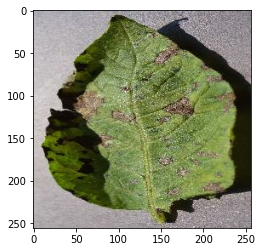

In [136]:
#printing my first image 
for image_batch,label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.imshow(image_batch[4].numpy().astype('uint8'))

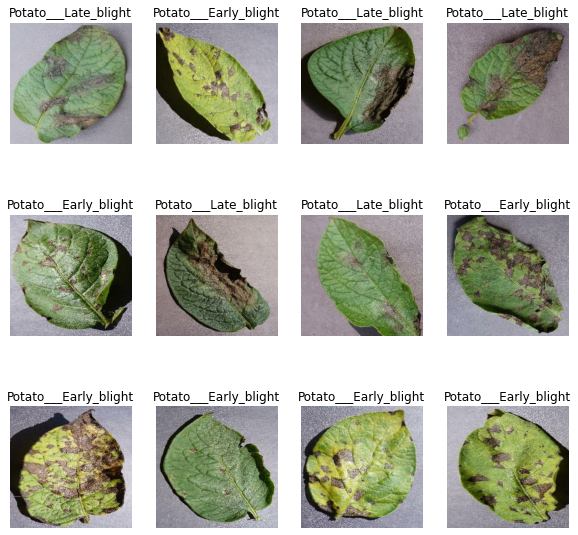

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
             ax=plt.subplot(3,4,i+1)
             plt.imshow(image_batch[i].numpy().astype('uint8'))
             plt.title(class_names[label_batch[i]])

             plt.axis("off")

In [13]:
len(dataset)

68

In [14]:
# 80% training, 10% validation, 10% test


In [15]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds=dataset.take(54)
len(train_ds)

54

In [17]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [18]:
val_size=0.1
val_size*len(dataset)


6.800000000000001

In [19]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [20]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [21]:
def get_datset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  ds_size=len(ds)

  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)



  return train_ds,val_ds,test_ds

In [22]:
train_ds,val_ds,test_ds=get_datset_partitions_tf(dataset)

In [23]:
len(train_ds)

54

In [24]:
len(test_ds)

8

In [25]:
len(val_ds)

6

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=8,
)

Epoch 1/8
54/54 [==============================] - 270s 5s/step - loss: 0.4445 - accuracy: 0.8061 - val_loss: 0.3447 - val_accuracy: 0.8490
Epoch 2/8
54/54 [==============================] - 270s 5s/step - loss: 0.3062 - accuracy: 0.8750 - val_loss: 0.2349 - val_accuracy: 0.8958
Epoch 3/8
54/54 [==============================] - 269s 5s/step - loss: 0.2608 - accuracy: 0.9016 - val_loss: 0.2154 - val_accuracy: 0.9062
Epoch 4/8
54/54 [==============================] - 268s 5s/step - loss: 0.2052 - accuracy: 0.9172 - val_loss: 0.1492 - val_accuracy: 0.9271
Epoch 5/8
54/54 [==============================] - 270s 5s/step - loss: 0.1930 - accuracy: 0.9207 - val_loss: 0.0979 - val_accuracy: 0.9583
Epoch 6/8
54/54 [==============================] - 268s 5s/step - loss: 0.1956 - accuracy: 0.9236 - val_loss: 0.1731 - val_accuracy: 0.9271
Epoch 7/8
54/54 [==============================] - 269s 5s/step - loss: 0.1765 - accuracy: 0.9369 - val_loss: 0.1048 - val_accuracy: 0.9531
Epoch 8/8
54/54 [===

In [45]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 11s 1s/step - loss: 0.1637 - accuracy: 0.9336


In [46]:
scores

[0.1637440025806427, 0.93359375]

In [47]:
history

In [48]:
history.params

{'verbose': 1, 'epochs': 8, 'steps': 54}

In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
history.history['accuracy']

[0.8061342835426331,
 0.875,
 0.9016203880310059,
 0.9172453880310059,
 0.9207175970077515,
 0.9236111044883728,
 0.9369212985038757,
 0.9386574029922485]

In [51]:
history.history['loss']

[0.4445199966430664,
 0.30619072914123535,
 0.26080870628356934,
 0.20518949627876282,
 0.19299471378326416,
 0.1955665796995163,
 0.1765119582414627,
 0.16482627391815186]

In [60]:
acc=history.history['accuracy']
val_ac=history.history['val_accuracy']
loss=history.history ['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'training and  validation accuracy')

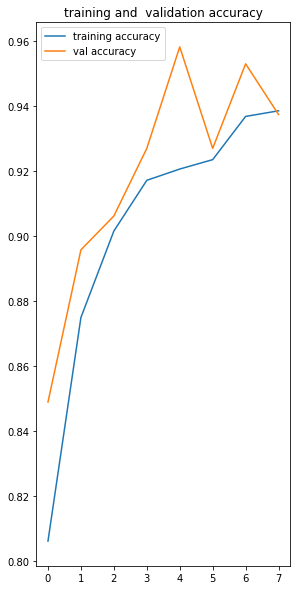

In [69]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='training accuracy')
plt.plot(range(EPOCHS),val_ac,label='val accuracy')
plt.legend()
plt.title('training and  validation accuracy')

Text(0.5, 1.0, 'training and  loss')

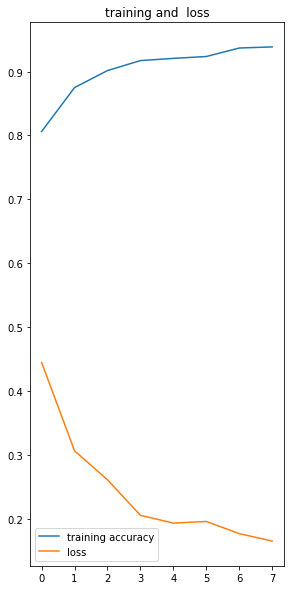

In [71]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='training accuracy')
plt.plot(range(EPOCHS),loss,label='loss')
plt.legend()
plt.title('training and  loss')

print first image to predict
my actual label: Potato___Early_blight
1/1 [==============================] - 3s 3s/step
[5.8657563e-01 4.1342348e-01 9.3120173e-07]


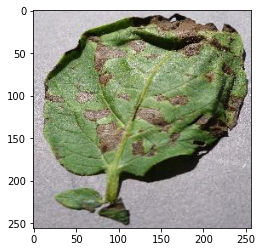

In [97]:
for image_batch,label_batch in test_ds.take(1):
 first_image= image_batch[0].numpy().astype('uint8')
 first_batch=label_batch[0].numpy()
 print('print first image to predict')
 plt.imshow(first_image)
 print('my actual label:' ,class_names[first_batch])
 batch_prediction=model.predict(image_batch)
 print(batch_prediction[0])
 

In [100]:
import  numpy as np
np.argmax([5.8657563e-01 ,4.1342348e-01, 9.3120173e-07])

0

print first image to predict
my actual label: Potato___healthy
1/1 [==============================] - 1s 1s/step
predcited: Potato___healthy


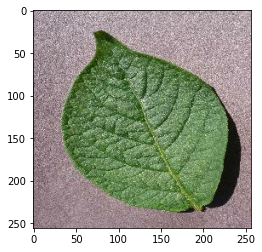

In [111]:
for image_batch,label_batch in test_ds.take(1):
 first_image= image_batch[0].numpy().astype('uint8')
 first_batch=label_batch[0].numpy()
 print('print first image to predict')
 plt.imshow(first_image)
 print('my actual label:' ,class_names[first_batch])
 batch_prediction=model.predict(image_batch)
 print('predcited:',class_names[np.argmax([batch_prediction[0]])])

In [149]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 97ms/step


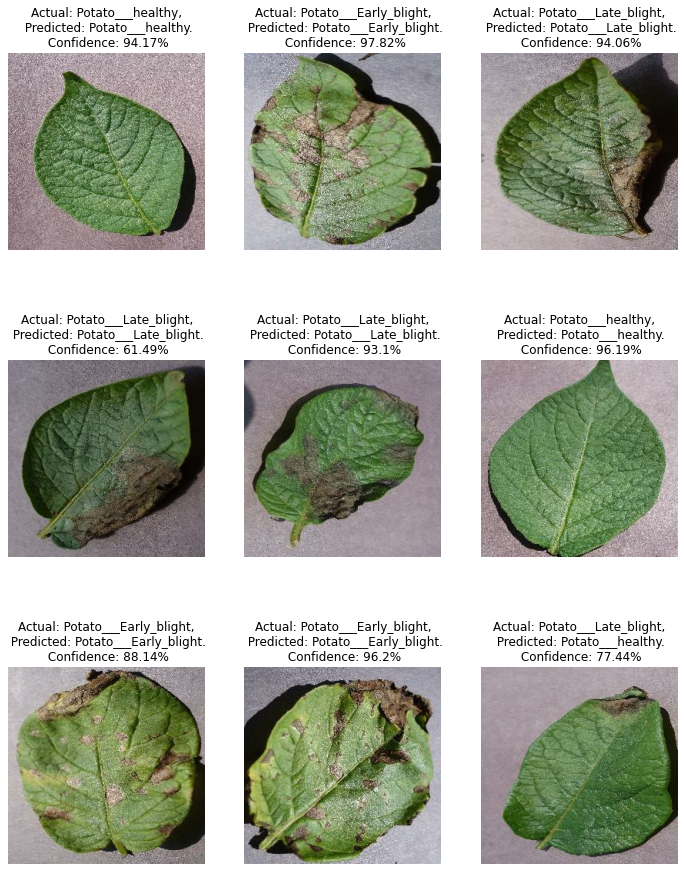

In [152]:
plt.figure(figsize=(12, 16))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")